# Next character prediction (Text generation) in English Language

## Importing the necessary libraries

In [52]:
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import Counter
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

## BPE Tokenizer

In [53]:
class BPETokenizer:
  def __init__(self):
    self.vocab = {}
    self.inverse_vocab = {}
    self.merges = {}

  def train(self, text, vocab_size):
    unique_chars = []

    unique_chars = [chr(i) for i in range(256)]
    text_chars = set(text)

    unique_chars.extend(char for char in sorted(text_chars) if char not in unique_chars)
    # print(unique_chars)

    self.vocab = {i:char for i, char in enumerate(unique_chars)}
    # print("Initial vocab list :: ",self.vocab)
    self.inverse_vocab = {char:i for i, char in enumerate(unique_chars)}

    sequence = [self.inverse_vocab[char] for char in text]

    # print("Len of my vocab", len(self.vocab))

    while len(self.vocab) < vocab_size:
      pair_counts = Counter(zip(sequence,sequence[1:]))

      if not pair_counts:
        break

      best_pair = max(pair_counts.items(), key = lambda x: x[1])[0]

      new_token_id = max(self.vocab.keys()) + 1

      self.merges[best_pair] = new_token_id

      merge_symbol = self.vocab[best_pair[0]] + self.vocab[best_pair[1]]

      self.vocab[new_token_id] = merge_symbol
      self.inverse_vocab[merge_symbol] = new_token_id


      new_seq = []
      i = 0
      while i < len(sequence):
          if i < len(sequence)-1 and (sequence[i], sequence[i+1]) == best_pair:
              new_seq.append(new_token_id)
              i += 2
          else:
              new_seq.append(sequence[i])
              i += 1
      sequence = new_seq

  def encode(self,text):
    tokens = [self.inverse_vocab[ch] for ch in text]
    for pair, new_id in self.merges.items():
        new_tokens, i = [], 0
        while i < len(tokens):
            if i < len(tokens)-1 and (tokens[i], tokens[i+1]) == pair:
                new_tokens.append(new_id)
                i += 2
            else:
                new_tokens.append(tokens[i])
                i += 1
        tokens = new_tokens
    return tokens


  def decode(self,tokens):
    return ''.join(self.vocab[token] for token in tokens)

### Trial (BPE Tokenizer) initialization , training, encoding, decoding

In [54]:
tokenizer = BPETokenizer()

text = "the cat in the mat"

print("The original text is ::", text)

tokenizer.train(text, vocab_size=260)

tokens = tokenizer.encode(text)
print("The encoded text is ::", tokens)

text = tokenizer.decode(tokens)
print("The decoded encoded text is :: ",text)

The original text is :: the cat in the mat
The encoded text is :: [258, 99, 259, 32, 105, 110, 32, 258, 109, 259]
The decoded encoded text is ::  the cat in the mat


## Creating a RNN now for text generation using the above created BPE Tokenizer

In [55]:
class MyRNN(nn.Module):
  def __init__(self, embedding_size, hidden_size, vocab_size):
    super(MyRNN, self).__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_size)
    self.lstm = nn.LSTM(embedding_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, vocab_size)

  def forward(self, x):
    emb = self.embedding(x) # [ B, Seq_L, Emb_S]
    out, _ = self.lstm(emb) # [B, Seq_L, hidden_size]
    out = out[:,-1,:] # [B, hidden_size]
    out = self.fc(out) # [B, vocab_size]
    return out

## Reading from the dataset file

In [56]:
with open('raw_text.txt', 'r', encoding = 'utf-8') as file:
    raw_text = file.read()

## Initializing the tokenizer and training it

In [57]:
tokenizer = BPETokenizer()
tokenizer.train(raw_text, vocab_size= 600)

### Encoding the read data

In [58]:
encoded = tokenizer.encode(raw_text)

In [59]:
seq_len = 10

X = []
y = []

for i in range(len(encoded)- seq_len):
  X.append(encoded[i:i+seq_len])
  y.append(encoded[i+seq_len])

In [60]:
X = torch.tensor(X)
y = torch.tensor(y)

print(X.shape)
print(y.shape)

torch.Size([217, 10])
torch.Size([217])


In [61]:
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [62]:
print(len(dataloader))

7


### Model intialization

In [63]:
model = MyRNN(embedding_size=64, hidden_size=128, vocab_size=len(tokenizer.vocab))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Training

In [66]:
num_epochs = 100
loss_list = []

for epoch in range(num_epochs):
    model.train()
    for batch_x, batch_y in dataloader:
        optimizer.zero_grad()
        logits = model(batch_x)

        loss = criterion(logits, batch_y)
        loss_list.append(loss.item())

        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} Loss: {loss.item():.4f}")

Epoch 1 Loss: 6.2515
Epoch 2 Loss: 6.1893
Epoch 3 Loss: 5.8939
Epoch 4 Loss: 4.9905
Epoch 5 Loss: 4.7023
Epoch 6 Loss: 4.5544
Epoch 7 Loss: 4.2539
Epoch 8 Loss: 4.3837
Epoch 9 Loss: 4.2575
Epoch 10 Loss: 4.2596
Epoch 11 Loss: 3.7933
Epoch 12 Loss: 3.8151
Epoch 13 Loss: 3.5588
Epoch 14 Loss: 3.3881
Epoch 15 Loss: 3.3740
Epoch 16 Loss: 3.2555
Epoch 17 Loss: 2.9398
Epoch 18 Loss: 2.8987
Epoch 19 Loss: 2.7677
Epoch 20 Loss: 2.6274
Epoch 21 Loss: 2.6530
Epoch 22 Loss: 2.4473
Epoch 23 Loss: 2.2155
Epoch 24 Loss: 2.1109
Epoch 25 Loss: 1.9828
Epoch 26 Loss: 1.7868
Epoch 27 Loss: 1.8864
Epoch 28 Loss: 1.6458
Epoch 29 Loss: 1.5974
Epoch 30 Loss: 1.5359
Epoch 31 Loss: 1.4147
Epoch 32 Loss: 1.2945
Epoch 33 Loss: 1.2358
Epoch 34 Loss: 1.1250
Epoch 35 Loss: 1.0864
Epoch 36 Loss: 0.9760
Epoch 37 Loss: 0.9667
Epoch 38 Loss: 0.8768
Epoch 39 Loss: 0.8501
Epoch 40 Loss: 0.8089
Epoch 41 Loss: 0.7387
Epoch 42 Loss: 0.6712
Epoch 43 Loss: 0.6876
Epoch 44 Loss: 0.6045
Epoch 45 Loss: 0.5754
Epoch 46 Loss: 0.53

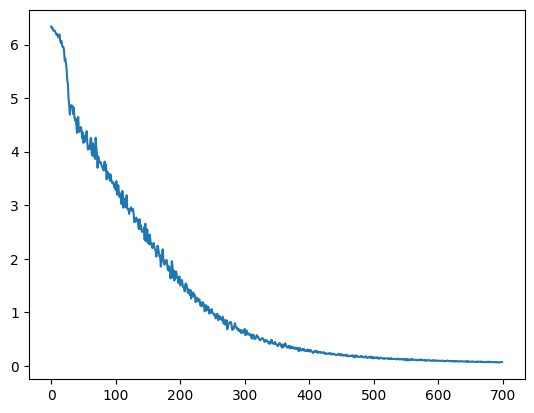

In [67]:
plt.plot(loss_list)

In [68]:
def generate(model, tokenizer, text, length):

    model.eval()

    tokens = tokenizer.encode(text)
    print("The length of the tokens is :: ",len(tokens))

    for i in range(length):
        input_seq = tokens[-seq_len:]
        input_tensor = torch.tensor([input_seq])

        with torch.no_grad():
            logits = model(input_tensor)
            next_token = torch.argmax(logits, dim=-1).item()
            tokens.append(next_token)

    return tokenizer.decode(tokens)

### Inference Trial

In [69]:
new_text = generate(model, tokenizer, "Her faced lifted with joy ", 50)
print(new_text)

The length of the tokens is ::  14
Her faced lifted with joy  f ged ed Mr. Brown tiyher y, and then he smiled. "Let's see if we can find it!" Together, they walked to the riverbank, w


In [70]:
a = [[1,2],[3,4],[5,6]]
a = torch.tensor(a)
print(a)

print(torch.argmax(a, dim = -1))

tensor([[1, 2],
        [3, 4],
        [5, 6]])
tensor([1, 1, 1])


## WordPiece Tokenizer

In [35]:
from collections import defaultdict

In [50]:
class WordPieceTokenizer:
  def __init__(self):
    self.vocab = {}
    self.inverse_vocab = {}
    self.merges = {}

  def train(self, text, vocab_size):
    print("The passed text is :: ",text)
    all_words = text.split()
    word_freq = Counter (all_words)
    print("Word freq :: ",word_freq)

    unique_words = set(all_words)

    subwords = set()
    subwords.add(' ')

    for word in word_freq:
        for char in word:
            subwords.add(char)
    characters = sorted(list(subwords))
    print(subwords)

    self.vocab = {i: char for i, char in enumerate(characters)}
    print("Initial vocab :: ",self.vocab)
    self.inverse_vocab = {char: i for i, char in enumerate(characters)}
    print("Initial inverse vocab :: ",self.inverse_vocab)

    word_segments = {word: list(word) for word in word_freq}
    print(word_segments)

    while len(self.vocab) < vocab_size:
      pair_counts = {}
      for word,segment in word_segments.items():
        freq = word_freq[word]

        for i in range(len(segment)-1):
          pair = (segment[i],segment[i+1])
          pair = (self.inverse_vocab[pair[0]], self.inverse_vocab[pair[1]])
          pair_counts[pair] = pair_counts.get(pair, 0)
          pair_counts[pair] += freq

        if not pair_counts:
          break

        best_pair = max(pair_counts.items(), key = lambda x: x[1])[0]
        new_token_id = max(self.vocab.keys()) + 1
        self.merges[best_pair] = new_token_id

        merge_symbol = self.vocab[best_pair[0]] + self.vocab[best_pair[1]]
        self.vocab[new_token_id] = merge_symbol
        # print("After vocab :: ",self.vocab)
        # self.inverse_vocab[merge_symbol] = new_token_id
        # print("Afte invese vocab :: ",self.inverse_vocab)
        # break




In [51]:
w = WordPieceTokenizer()
text = "low lower lowest"
w.train(text, 260)

The passed text is ::  low lower lowest
Word freq ::  Counter({'low': 1, 'lower': 1, 'lowest': 1})
{'o', 'w', 'l', 's', 'r', ' ', 't', 'e'}
Initial vocab ::  {0: ' ', 1: 'e', 2: 'l', 3: 'o', 4: 'r', 5: 's', 6: 't', 7: 'w'}
Initial inverse vocab ::  {' ': 0, 'e': 1, 'l': 2, 'o': 3, 'r': 4, 's': 5, 't': 6, 'w': 7}
{'low': ['l', 'o', 'w'], 'lower': ['l', 'o', 'w', 'e', 'r'], 'lowest': ['l', 'o', 'w', 'e', 's', 't']}
